In [1]:
import bunny
bunny

<module 'bunny' from '/projects/SpectralVAEGAN/src/applications/bunny.py'>

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join('..')))
sys.path.insert(0, os.path.abspath(os.path.join('../core')))
import numpy as np
import pickle
import numpy as np
from functools import partial
import tensorflow as tf

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Lambda, Subtract, Dense
from keras.layers.merge import _Merge
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.losses import mse

import train
import costs
from data import predict_with_K_fn
from layer import stack_layers
from util import LearningHandler, make_layer_list, train_gen, get_scale

from sklearn.manifold import TSNE

debug = False

if debug:
    from tensorflow.python import debug as tf_debug

    K.set_session(tf_debug.LocalCLIDebugWrapperSession(K.get_session()))

%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    pass

Using TensorFlow backend.


# DATASET AND USEFUL FUNCTION DEFINITIONS

In [3]:
def tf_get(input_tensors, output_tensors, input_data):
    input_data = input_data if isinstance(input_data, list) else [input_data]
    input_tensors, output_tensors = list(input_tensors), list(output_tensors)
    sess = K.get_session()
    return sess.run(output_tensors, dict(zip(input_tensors, input_data)))

In [4]:
def predict_with_K_fn(K_fn, x, bs=1000):
    '''
    Convenience function: evaluates x by K_fn(x), where K_fn is
    a Keras function, by batches of size 1000.
    '''
    if not isinstance(x, list):
        x = [x]
    num_outs = len(K_fn.outputs)
    shapes = [list(output_.get_shape()) for output_ in K_fn.outputs]
    shapes = [[len(x[0])] + s[1:] for s in shapes]
    y = [np.empty(s) for s in shapes]
    recon_means = []
    for i in range(int((x[0].shape[0]-1)/bs + 1)):
        x_batch = []
        for x_ in x:
            x_batch.append(x_[i*bs:(i+1)*bs])
        temp = K_fn(x_batch)
        for j in range(num_outs):
            y[j][i*bs:(i+1)*bs] = temp[j]

    return y

In [5]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def imscatter(x, y, samples, shape, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    m=samples.shape[0]
    i=0
    for x0, y0  in zip(x, y):
        im = OffsetImage(samples[i].reshape(shape), zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
        i=i+1
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('paper')
from matplotlib.colors import ListedColormap
# cmap1 = ListedColormap(sns.color_palette().as_hex())
# cmap2 = ListedColormap(sns.color_palette('bright').as_hex())
def plot(x, y=None, x2=None, y2=None, s=10, s2=None, alpha=0.5, alpha2=None, label1=None, label2=None, cmap1=None, cmap2=None, n_imgs=4, shuffle=True):
    s2 = s if s2 is None else s2
    alpha2 = alpha if alpha2 is None else alpha2
    n = x.shape[1]
    if n == 1:
        g = plt.figure()
        plt.scatter(np.zeros((n,)), x[:,1], c=y, s=s, alpha=alpha, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(np.zeros((n,)), x2[:,1], c=y2, s=s2, alpha=alpha2, label=label2, cmap=cmap2)
    if n == 3:
        %matplotlib notebook
        g = plt.figure()
        ax = g.add_subplot(111, projection='3d')
        ax.set_axis_off()
        ax.scatter(x[:,0], x[:,1], x[:,2], c=y, s=s, alpha=alpha, label=label1)
        if x2 is not None:
            ax.scatter(x2[:,0], x2[:,1], x2[:,2], c=y2, s=s2, alpha=alpha2, label=label2)
        g = (g, ax)
    elif n == 784:
        %matplotlib inline
        n_imgs = min(n_imgs, len(x))
        # num = 7
        # sub = y == num
        sub = y == y
        
        if x2 is None:
            g, axarr = plt.subplots(n_imgs, n_imgs)
            if shuffle:
                p = np.random.permutation(len(x[sub]))
            else:
                p = np.arange(len(x[sub]))
            n = 0
            while n < n_imgs * n_imgs:
                i, j = int(n / n_imgs), n % n_imgs
                axarr[i,j].axis('off')
                if n < len(x[sub]):
                    axarr[i,j].imshow(x[sub][p[n]].reshape(28, 28))
                n += 1
        elif x2 is not None:
            p = np.random.permutation(len(x[sub]))[:n_imgs]
            for i in range(n_imgs):
                idx = p[i]
                plt.subplot(1,2,1)
                plt.imshow(x2[sub][idx].reshape(28, 28))
                plt.subplot(1,2,2)
                plt.imshow(x[sub][idx].reshape(28, 28))
                g = plt.figure()
    else:
        g = plt.figure()
        plt.scatter(x[:,0], x[:,1], c=y, s=s, alpha=alpha, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(x2[:,0], x2[:,1], c=y2, s=s2, alpha=alpha2, label=label2, cmap=cmap2)
            
    if label1 is not None or label2 is not None:
        plt.legend()
        
    return g

In [7]:
def generate_bunny(n=2000, train_set_fraction=.8):
    import bunny
    a = [np.expand_dims(np.array(bunny.trace2[c]), axis=-1) for c in ['x', 'y', 'z']]
    x = np.concatenate(a, axis=-1)
    x = x.astype(np.float32)
    x = x[np.logical_not(np.any(np.isnan(x), axis=1))]
    y = np.arange(len(x))
    
    # shuffle
    p = np.random.permutation(len(x))[:n]
    y = y[p]
    x = x[p]
    
    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()
    
    return (x_train, y_train), (x_test, y_test)

def generate_sphere(n=1200, train_set_fraction=.8):
    r = 1
    alpha = 4.0*np.pi*r*r/(n+1)
    d = np.sqrt(alpha)
    m_nu = int(np.round(np.pi/d))
    d_nu = np.pi/m_nu
    d_phi = alpha/d_nu
    count = 0
    coords = [[], [], []]
    y = []
    for i in range(0, m_nu):
        nu = np.pi*(i+0.5)/m_nu
        m_phi = int(np.round(2*np.pi*np.sin(nu)/d_phi))
        for j in range(0, m_phi):
            phi = 2*np.pi*j/m_phi
            xp = r*np.sin(nu)*np.cos(phi)
            yp = r*np.sin(nu)*np.sin(phi)
            zp = r*np.cos(nu)
            coords[0].append(xp)
            coords[1].append(yp)
            coords[2].append(zp)
            y.append(i + j)
            count = count +1
            
    x = np.array(coords).T
    y = np.array(y).T
        
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]
    
    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()
    
    return (x_train, y_train), (x_test, y_test)

def generate_plane(n=1200, train_set_fraction=.8):
    # compute number of points in each dimension
    n_i = np.int(np.sqrt(n))
    n = n_i ** 2
    
    # compute points on this grid
    t = np.mgrid[0:1:1/n_i, 0:1:1/n_i].reshape(2,-1).T
    t = np.concatenate([t, np.zeros(shape=(len(t),1))], axis=1)
    
    # compute rotation
    A = np.random.normal(size=(3, 3))
    A, _ = np.linalg.qr(A)
    
    x = np.dot(A, t.T).T
    
    # y is the sum of the ts
    y = t[:,0] + t[:,1]
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    print(n_train)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()
    
    return (x_train, y_train), (x_test, y_test)

def generate_loop(n=1200, train_set_fraction=.8):
    t = np.linspace(0, 2*np.pi, num=n+1)[:-1]
    
    # generate all three coordinates
    x = np.empty((n, 3))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(2*t)
    x[:,2] = np.sin(3*t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_circle(n=1000, train_set_fraction=.8, alpha=4):
    t = np.linspace(0, 2*np.pi, num=n+1)[:-1]
#     t = np.log(np.linspace(1, alpha, num=n))
    t = t / np.max(t) * 2 * np.pi
    
    # generate all three coordinates
    x = np.empty((n, 2))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_line(n=1200, train_set_fraction=.8):
    pts_per_cluster = int(n / 2)
    x1 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x2 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x = np.concatenate([x1, x2], axis=1)
    
    # generate labels
#     y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)
    y = x1
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_gaussians(n=1200, n_clusters=2, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / n_clusters)
    r = 1
    
    clusters = []
    
    for x in np.linspace(0, 1, num=n_clusters):
        clusters.append(np.random.normal(x, noise_sigma, size=(pts_per_cluster, 2)))

    # combine clusters
    x = np.concatenate(clusters, axis=0)
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_cc(n=1200, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / 2)
    r = 1

    # generate clusters
    theta1 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)
    theta2 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)

    cluster1 = np.concatenate((np.cos(theta1) * r, np.sin(theta1) * r), axis=1)
    cluster2 = np.concatenate((np.cos(theta2) * r, np.sin(theta2) * r), axis=1)

    # shift and reverse cluster 2
    cluster2[:, 0] = -cluster2[:, 0] + 0.5
    cluster2[:, 1] = -cluster2[:, 1] - 1

    # combine clusters
    x = np.concatenate((cluster1, cluster2), axis=0)

    # add noise to x
    x = x + np.random.randn(x.shape[0], 2) * noise_sigma
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_faces(train_set_fraction=.8):
    x = np.array(loadmat('frey_rawface.mat')['ff']).T
    y = np.arange(len(x)) / len(x)
    
    n = len(x)
    
    # shuffle
    p = np.random.permutation(len(x))[:n]
    y = y[p]
    x = x[p]
    
    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()
    
    return (x_train, y_train), (x_test, y_test)

In [8]:
dataset = 'loop'

if dataset == 'mnist':
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255 
    latent_dim = 10
if dataset == 'mnist_9':
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    train_9s, test_9s = y_train == 9, y_test == 9
    x_train, x_test = x_train[train_9s], x_test[test_9s]
    y_train, y_test = y_train[train_9s], y_test[test_9s]
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255
    latent_dim = 3
elif dataset == 'gaussians':
    (x_train, y_train), (x_test, y_test) = generate_gaussians(n=2000, n_clusters=2, train_set_fraction=0.85)
    latent_dim = 5
elif dataset == 'line':
    (x_train, y_train), (x_test, y_test) = generate_line(n=2000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=5000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'cc':
    (x_train, y_train), (x_test, y_test) = generate_cc(n=2000, noise_sigma=0.01, train_set_fraction=0.85)
    latent_dim = 3
elif dataset == 'circle':
    (x_train, y_train), (x_test, y_test) = generate_circle(n=1024, train_set_fraction=0.85, alpha=30)
    latent_dim = 2
elif dataset == 'plane':
    (x_train, y_train), (x_test, y_test) = generate_plane()
    latent_dim = 3
elif dataset == 'sphere':
    (x_train, y_train), (x_test, y_test) = generate_sphere(n=2000)
    latent_dim = 3
elif dataset == 'bunny':
    (x_train, y_train), (x_test, y_test) = generate_bunny(n=20000)
    latent_dim = 3
elif dataset == 'faces':
    (x_train, y_train), (x_test, y_test) = generate_faces()
    latent_dim = 2

x_all = np.concatenate([x_train, x_test], axis=0)
    
# normalize to between -1 and 1
if 'mnist' not in dataset:
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b
print('IMPORTANT: max {}, min {}'.format(np.max(x_train), np.min(x_train)))

# arch = [
#     {'type': 'relu', 'size': 128},
#     {'type': 'relu', 'size': 128},
#     {'type': 'relu', 'size': 512},
#     {'type': 'linear', 'size': 16},
#     ]
arch = [
    {'type': 'relu', 'size': 128},
    {'type': 'relu', 'size': 128},
    {'type': 'linear', 'size': latent_dim},
    ]

IMPORTANT: max 1.0, min -1.0


# MODEL DEFINITIONS

In [9]:
class SpectralNet:
    def __init__(self, inputs, arch, spec_reg, y_true, y_train_labeled_onehot,
            n_clusters, affinity, scale_nbr, n_nbrs, batch_sizes, normalized=False,
            siamese_net=None, x_train=None, have_labeled=False, eps=1e-7):
        self.y_true = y_true
        self.y_train_labeled_onehot = y_train_labeled_onehot
        self.eps = eps
        self.inputs = inputs
        self.batch_sizes = batch_sizes
        self.normalized = normalized
        # generate layers
        self.layers = make_layer_list(arch[:-1], 'spectral', spec_reg)
        self.layers += [
                  {'type': 'linear',
                   'size': n_clusters,
                   'l2_reg': spec_reg,
                   'name': 'spectral_{}'.format(len(arch)-1)},
                  {'type': 'Orthonorm', 'name':'orthonorm'}
                  ]

        # create spectralnet
        self.outputs = stack_layers(self.inputs, self.layers)
        self.net = Model(inputs=self.inputs['Unlabeled'], outputs=self.outputs['Unlabeled'])

        # DEFINE LOSS

        # generate affinity matrix W according to params
        input_affinity = tf.concat([self.inputs['Unlabeled'], self.inputs['Labeled']], axis=0)
        x_affinity = x_train

        # calculate scale for affinity matrix
        scale = get_scale(x_affinity, self.batch_sizes['Unlabeled'], scale_nbr)

        # create affinity matrix
        if affinity == 'full':
            W = costs.full_affinity(input_affinity, scale=scale)
        elif affinity in ['knn', 'siamese']:
            W = costs.knn_affinity(input_affinity, n_nbrs, scale=scale, scale_nbr=scale_nbr)

        y_ = self.outputs['Unlabeled']
            
        if self.normalized:
            # compute the row and column denominators
            row_norm = 1 / tf.reduce_sum(W, axis=1)
            col_norm = 1 / tf.reduce_sum(W, axis=0)
            
            # apply them
            W = tf.einsum('j,ij->ij', col_norm, tf.einsum('i,ij->ij', row_norm, W))
            
            # compute D^{-1/2} and apply it
            self.D_half_inv = dhv = tf.sqrt((1 / tf.reduce_sum(W, axis=1)) + self.eps)
            W = tf.einsum('j,ij->ij', dhv, tf.einsum('i,ij->ij', dhv, W))
#             print('SHAPES:', y_.shape, dhv.shape)
#             self.normalized_output = np.einsum('ij,i->ij', y_, dhv)
            self.normalized_output = y_ * tf.expand_dims(dhv, -1)
            
#             # compute D and apply it
#             self.D = 1 / tf.reduce_sum(W, axis=1) + self.eps
#             W = tf.einsum('i,ij->ij', self.D, W)
#             W = tf.Print(W, [tf.reduce_sum(W, axis=1), tf.linalg.norm(W - tf.transpose(W))], 'WHOA ', summarize=100)
            
#             # now expose only the right eigenvector:
#             W = tf.matmul(W, W, transpose_a=True)
            
#             ones = tf.ones(shape=(tf.shape(W)[0], 1))
#             W = tf.Print(W, [tf.matmul(W, ones), tf.linalg.norm(tf.matmul(W, ones) - ones)], 'SHOULD BE ZERO', summarize=100)
        
        
        self.Dy = costs.squared_distance(y_)

        # define loss
        self.loss = K.sum(W * self.Dy) / (2 * batch_sizes['Unlabeled'])

        # create the train step update
        self.learning_rate = tf.Variable(0., name='spectral_net_learning_rate')
#         self.train_step = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
        self.train_step = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
        
        # initialize spectralnet variables
        K.get_session().run(tf.variables_initializer(self.net.trainable_weights))

    def train(self, x_train_unlabeled, x_train_labeled, x_val_unlabeled,
            lr, drop, patience, num_epochs):
        # create handler for early stopping and learning rate scheduling
        self.lh = LearningHandler(
                lr=lr,
                drop=drop,
                lr_tensor=self.learning_rate,
                patience=patience)

        losses = np.empty((num_epochs,))
        val_losses = np.empty((num_epochs,))

        # begin spectralnet training loop
        self.lh.on_train_begin()
        i = 0
        for i in range(num_epochs):
            # train spectralnet
            losses[i] = train.train_step(
                    return_var=[self.loss],
                    updates=self.net.updates + [self.train_step],
                    x_unlabeled=x_train_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    batch_sizes=self.batch_sizes,
                    x_labeled=x_train_labeled,
                    y_labeled=self.y_train_labeled_onehot,
                    batches_per_epoch=100)[0]

            # get validation loss
            val_losses[i] = train.predict_sum(
                    self.loss,
                    x_unlabeled=x_val_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    x_labeled=x_train_unlabeled[0:0],
                    y_labeled=self.y_train_labeled_onehot,
                    batch_sizes=self.batch_sizes)

            # do early stopping if necessary
            if self.lh.on_epoch_end(i, val_losses[i]):
                print('STOPPING EARLY')
                break

            # print training status
            print("Epoch: {}, loss={:2f}, val_loss={:2f}".format(i, losses[i], val_losses[i]))

        return losses[:i+1], val_losses[:i+1]
    
    def predict(self, x):
        # test inputs do not require the 'Labeled' input
        inputs_test = {'Unlabeled': self.inputs['Unlabeled'], 'Orthonorm': self.inputs['Orthonorm'], 'Labeled':self.inputs['Labeled']}
        pred_tensor = self.normalized_output if self.normalized else self.outputs['Unlabeled']
#         if self.normalized:
#             print("SHAPE,", tf.concat([tf.expand_dims(self.D_half, -1)]*3, axis=-1))
#             Y, D_ = train.predict(
#                         [self.outputs['Unlabeled'], self.D_half],
#                         x_unlabeled=x,
#                         inputs=inputs_test,
#                         y_true=self.y_true,
#                         x_labeled=x[0:0],
#                         y_labeled=self.y_train_labeled_onehot[0:0],
#                         batch_sizes=self.batch_sizes)
#             return Y, D_
#         else:
        return train.predict(
                    pred_tensor,
                    x_unlabeled=x,
                    inputs=inputs_test,
                    y_true=self.y_true,
                    x_labeled=x[0:0],
                    y_labeled=self.y_train_labeled_onehot[0:0],
                    batch_sizes=self.batch_sizes)

In [10]:
# def kl_loss(_, __):
#             log_e = tf.log(self.e + self.eps)
# #             kl_loss = -1 + tf.log(self.alpha) - log_e + self.e/self.alpha
# #             self.kl_loss = K.sum(kl_loss) * 0.5
#             # find local neighborhood of each point in batch
#             D = self.pairwise_distances(self.z, self.mu)
#             n_batch = tf.shape(D)[-1]
#             idx = pick_nearest_k(D, self.k, drop_self=True)
#             omn = mu_neighborhood = tf.gather_nd(self.mu, idx)
#             print("MU_NEIGHBORHOOD", mu_neighborhood.shape)
#             mu_neighborhood = tf.reshape(mu_neighborhood, shape=(n_batch, self.k, self.latent_dim))
#             print("MU_NEIGHBORHOOD", mu_neighborhood.shape)
            
#             # obtain covariance of each local neighborhood
#             input_cov = tf.einsum('ikj,ikl->ijl', mu_neighborhood, mu_neighborhood)
#             input_cov = tf.Print(input_cov, [tf.shape(omn), tf.shape(mu_neighborhood), omn[:self.k], mu_neighborhood[0,:,:]], summarize=10)
            
#             # obtain eigendecomposition of local neighborhood
#             cov_e, cov_v = tf.linalg.eigh(input_cov)
#             # normalize covariance so that largest eigenvalue is 1
#             cov_e = tf.einsum('ij,i->ij', cov_e, 1 / tf.reduce_max(cov_e, axis=1))
#             # threshold covariance so we only keep those above 1e-3
#             mean_cov_e = tf.reduce_mean(cov_e, axis=0)
#             rank = tf.shape(mean_cov_e)[0] - tf.shape(tf.where(mean_cov_e < 1e-2))[0]
#             rank = tf.Print(rank, [rank, tf.shape(mean_cov_e), mean_cov_e], 'rank! ')
#             # take log (used in final loss) BEFORE truncating
#             log_cov_e = tf.log(cov_e + self.eps)
            
#             # now truncate
#             cov_e, cov_v = cov_e[:,-rank:], cov_v[:,:,-rank:]
            
#             cov_e *= self.alpha
#             cov_e = tf.Print(cov_e, [cov_e], 'COV_E')
            
#             # compute trace of Sigma_cov^{-1} Sigma_theta
#             left = tf.einsum('ijk,ik->ijk', cov_v, 1 / (cov_e + self.eps))
#             v = tf.reshape(self.v, (n_batch, self.latent_dim, self.latent_dim))
#             right = tf.einsum('ijk,ik->ijk', v, self.e)
#             half_prod = tf.einsum('ikj,ikl->ijl', left, right)
#             trace = tf.linalg.svd(half_prod, compute_uv=False)
            
#             # compute KL divergence
# #             trace = tf.Print(trace, [K.sum(trace), K.sum(log_cov_e), K.sum(log_e)], 'trace, log_cov_e, log_e ')
#             trace = tf.Print(trace, [tf.einsum('ikj,ikl->ijl', cov_v, v)], 'agreement ', summarize=self.latent_dim * self.latent_dim)
#             self.kl_loss = K.sum(log_cov_e - log_e - 1 + trace)
#             return self.kl_loss

In [11]:
# def kl_loss(_, __):
# #             log_e = tf.log(self.e + self.eps)
# #             kl_loss = -1 + tf.log(self.alpha) - log_e + self.e/self.alpha
# #             self.kl_loss = K.sum(kl_loss) * 0.5
#             # find local neighborhood of each point in batch
#             D = self.pairwise_distances(self.z, self.mu)
#             n_batch = tf.shape(D)[-1]
#             idx = pick_nearest_k(D, self.k, drop_self=True)
#             omn = mu_neighborhood = tf.gather_nd(self.mu, idx)
#             print("MU_NEIGHBORHOOD", mu_neighborhood.shape)
#             mu_neighborhood = tf.reshape(mu_neighborhood, shape=(n_batch, self.k, self.latent_dim))
#             print("MU_NEIGHBORHOOD", mu_neighborhood.shape)
            
#             # obtain covariance of each local neighborhood
#             input_cov = tf.einsum('ikj,ikl->ijl', mu_neighborhood, mu_neighborhood)
#             input_cov = tf.Print(input_cov, [tf.shape(omn), tf.shape(mu_neighborhood), omn[:self.k], mu_neighborhood[0,:,:]], summarize=10)
            
#             diff_cov = (self.cov - input_cov)
#             diff_v = self.z - self.mu
#             losses = tf.einsum('ij,ik->i', diff_v, tf.einsum('ijk,ik->ij', diff_cov, diff_v))
#             self.kl_loss = tf.reduce_mean(losses)
# #             self.kl_loss = tf.reduce_mean(tf.square(self.cov - self.alpha * input_cov))
#             self.kl_loss = tf.Print(self.kl_loss, [tf.shape(losses)], 'losses shape: ')
# #             # obtain eigendecomposition of local neighborhood
# #             cov_e, cov_v = tf.linalg.eigh(input_cov)
# #             # normalize covariance so that largest eigenvalue is 1
# #             cov_e = tf.einsum('ij,i->ij', cov_e, 1 / tf.reduce_max(cov_e, axis=1))
# #             # threshold covariance so we only keep those above 1e-3
# #             mean_cov_e = tf.reduce_mean(cov_e, axis=0)
# #             rank = tf.shape(mean_cov_e)[0] - tf.shape(tf.where(mean_cov_e < 1e-2))[0]
# #             rank = tf.Print(rank, [rank, tf.shape(mean_cov_e), mean_cov_e], 'rank! ')
# #             # take log (used in final loss) BEFORE truncating
# #             log_cov_e = tf.log(cov_e + self.eps)
            
# #             # now truncate
# #             cov_e, cov_v = cov_e[:,-rank:], cov_v[:,:,-rank:]
            
# #             cov_e *= self.alpha
# #             cov_e = tf.Print(cov_e, [cov_e], 'COV_E')
            
# #             # compute trace of Sigma_cov^{-1} Sigma_theta
# #             left = tf.einsum('ijk,ik->ijk', cov_v, 1 / (cov_e + self.eps))
# #             v = tf.reshape(self.v, (n_batch, self.latent_dim, self.latent_dim))
# #             right = tf.einsum('ijk,ik->ijk', v, self.e)
# #             half_prod = tf.einsum('ikj,ikl->ijl', left, right)
# #             trace = tf.linalg.svd(half_prod, compute_uv=False)
            
# #             # compute KL divergence
# # #             trace = tf.Print(trace, [K.sum(trace), K.sum(log_cov_e), K.sum(log_e)], 'trace, log_cov_e, log_e ')
# #             trace = tf.Print(trace, [tf.einsum('ikj,ikl->ijl', cov_v, v)], 'agreement ', summarize=self.latent_dim * self.latent_dim)
# #             self.kl_loss = K.sum(log_cov_e - log_e - 1 + trace)
#             return self.kl_loss

In [ ]:
def pick_nearest_k(D, k, drop_self=True, randomize=False):
            n_batch = tf.shape(D)[-1]
            if drop_self:
                _, idxs = tf.nn.top_k(-D, k=k+1)
                idxs = idxs[:,1:]
            else:
                _, idxs = tf.nn.top_k(-D, k=k)
            # create a random index 
            if randomize:
                range_D = tf.expand_dims(tf.range(n_batch * k), -1)
                p = tf.expand_dims(tf.random.uniform(shape=(n_batch * k,), maxval=k, dtype=tf.dtypes.int32), -1)
                p = tf.concat([range_D, p], axis=1)
                # draw from the top k values using this index
                idx = tf.expand_dims(tf.gather_nd(idxs, p), -1)
            else:
                print("IMPORTANT", idxs.shape)
                idx = tf.reshape(idxs, (n_batch * k, 1))
            
            return idx
        
class SVG:
    def __init__(self, inputs, spectralnet, orig_dim, remove_dim=0, 
                 pca=True, alpha=1., normalize_factor=.1, k=16, eps=1e-5, lam=1e-1):
        optimizer = 'adam'
#         optimizer = RMSprop(lr=0.00005)
        self.input = inputs['Unlabeled']
        self.orig_dim = orig_dim
        self.eps = eps
        self.lam = lam
        self.pca = pca
        self.alpha = float(alpha)
        self.k = k
        self.remove_dim = remove_dim
        
        self.x = x = self.copy_spectralnet(spectralnet)
        
        #
        # DEFINE ALL LOSSES
        #
        def top_k_loss(D, k):
            # get nearest (i.e., largest negative distance) neighbors of each point
            vals, _ = tf.nn.top_k(-D, k=k)

            # remove self as neighbor, negate to get positive distances again
            vals = -vals
                
            return K.sum(vals)
        def kl_loss(_, __):
            log_e = 2 * self.half_log_e
            v = tf.reshape(self.v, (-1, self.latent_dim, self.latent_dim))
            # find local neighborhood of each point in batch
            D = self.pairwise_distances(self.z, self.z_mu)
            n_batch = tf.shape(D)[-1]
            idx = pick_nearest_k(D, self.k, drop_self=True)
            omn = z_mu_nb = tf.gather_nd(self.z_mu, idx)
            z_mu_nb = tf.reshape(z_mu_nb, shape=(n_batch, self.k, self.latent_dim))
            print("z_mu_nb", z_mu_nb.shape)
            
            # obtain covariance of each local neighborhood
            cov_nb = tf.einsum('ikj,ikl->ijl', z_mu_nb, z_mu_nb)
            cov_nb = tf.Print(cov_nb, [tf.shape(omn), tf.shape(z_mu_nb), omn[:self.k], z_mu_nb[0,:,:]], summarize=10)
            
            # obtain eigendecomposition of local neighborhood
            e_nb, v_nb = tf.linalg.eigh(cov_nb)
            e_nb += self.lam
            
            # take log (used in final loss) BEFORE truncating
            log_e_nb = tf.log(e_nb + self.eps)
            
            e_nb *= self.alpha
            
            # compute trace of Sigma_cov^{-1} Sigma_theta
            inv_sigma_nb = tf.einsum('ijk,ilk->ijl', tf.einsum('ijk,ik->ijk', v_nb, 1 / e_nb), v_nb)
            
            sigma_vae = tf.einsum('ijk,ilk->ijl', tf.einsum('ijk,ik->ijk', v, self.e), v)
            half_prod = tf.einsum('ikj,ikl->ijl', inv_sigma_nb, sigma_vae)
            trace = tf.linalg.svd(half_prod, compute_uv=False)
            
            # compute KL divergence
#             trace = tf.Print(trace, [tf.einsum('ikj,ikl->ijl', cov_v, v)], 'agreement ', summarize=self.latent_dim * self.latent_dim)
            self.kl_loss = tf.reduce_sum(log_e_nb - log_e - 1 + trace)
            return self.kl_loss
        def pca_loss(_, __):
            if self.pca:
                self.pca_loss = K.sum(mse(self.pca_input, self.pca_recon)) * self.orig_dim
            else:
                self.pca_loss = tf.constant(0.)
            return self.pca_loss
        def manifold_loss(_, __):
            # involves two bursts, on-manifold burst and off-manifold burst
            z = self.z
            x_recon = self.x_recon
            
            # obtain pairwise distances (size(recon) x size(input))
            D = self.pairwise_distances(z, self.z_mu)
            n_batch = tf.shape(D)[-1]
            idx = pick_nearest_k(D, self.k, drop_self=True)
        
#             # compute on manifold loss
#             z_mu_nb = tf.gather_nd(self.z_mu, idx)
#             z = tf.reshape(tf.tile(tf.expand_dims(z, 1), [1, self.k, 1]), (self.k * n_batch, tf.shape(z)[1]))
#             self.on_manifold_loss = K.sum(mse(z_mu_nb, z)) / self.k
            self.on_manifold_loss = K.constant(0.)
            
            # now compute off manifold loss
            input_neighborhood = tf.gather_nd(self.input, idx)
            x_recon = tf.reshape(tf.tile(tf.expand_dims(x_recon, 1), [1, self.k, 1]), (self.k * n_batch, tf.shape(x_recon)[1]))
            self.off_manifold_loss = tf.reduce_sum(mse(input_neighborhood, x_recon)) / self.k
            
            return self.on_manifold_loss + self.off_manifold_loss
        def vae_loss(_, __):
            return self.loss
        
        #
        # DEFINE LAYERS
        #

        # create encoder
        self.x_enc = x_enc = self.build_encoder(x, remove_dim=remove_dim, pca=self.pca)
        self.encoder = Model(inputs=self.input, outputs=x_enc)

        # create decoder
        self.x_recon = x_recon = self.build_decoder(x_enc)
        self.decoder_input = Input(shape=(self.latent_dim,), name='UnlabeledInput')
        self.decoder_output = self.build_decoder(self.decoder_input)
        self.decoder = Model(inputs=self.decoder_input, outputs=self.decoder_output)
        
        # create normalized decoder
        x_enc_norm = self.build_encoder(x, normalize_cov=normalize_factor, pca=self.pca)
        self.x_recon_norm = self.build_decoder(x_enc_norm)
        
        if self.pca:
            self.pcae = Model(inputs=self.input, outputs=self.pca_recon)
            self.pc = Model(inputs=self.input, outputs=self.pc_embedding)
            self.pcae.compile(optimizer=optimizer, loss=pca_loss)
            
        #
        # COMPUTE LOSS
        #
        losses = [kl_loss, pca_loss, manifold_loss]
        self.init_losses = [l(None, None) for l in losses]
        loss_weights = [1, 0, 1]
        # initialize losses
        self.loss = sum([a * b if b != 0 else K.constant(0.) for a, b in zip(self.init_losses, loss_weights)])
        
        #
        # ASSEMBLE NETWORK
        #
        self.vae = Model(inputs=self.input, outputs=self.x_recon)
        self.vae.compile(optimizer=optimizer, loss=vae_loss)
        
    def pairwise_distances(self, A, B):
        r_A, r_B = tf.reduce_sum(A*A, 1), tf.reduce_sum(B*B, 1)

        # turn r into column vector
        r_A, r_B = tf.reshape(r_A, [-1, 1]), tf.reshape(r_B, [-1, 1])
        D = r_A - 2 * tf.matmul(A, B, transpose_b=True) + tf.transpose(r_B)

        return D
        
    def build_decoder(self, x, arch=[1024, 256, 256]):
        if not hasattr(self, 'decoder_layers'):
            self.decoder_layers = [Dense(a, activation='relu') for a in arch]
            self.decoder_layers.append(Dense(self.orig_dim, activation='linear'))

        for l in self.decoder_layers:
            x = l(x)
        
        return x
        
    def build_encoder(self, x, arch=[256, 256, 1024], pca=False, normalize_cov=False, no_noise=False, remove_dim=0):
        if pca and not hasattr(self, 'pca_layers'):
            self.pca_layers = [Dense(self.latent_dim, activation='linear'), 
                               Dense(self.spectralnet_dim, activation='linear')]
            
        if not hasattr(self, 'encoder_layers'):
            self.encoder_precov_layers = [Dense(a, activation='relu') for a in arch]
            self.encoder_precov_layers.append(Dense(self.latent_dim * self.latent_dim, activation='linear'))
            self.encoder_eig_layers = [Dense(a, activation='relu') for a in arch]
            self.encoder_eig_layers.append(Dense(self.latent_dim, activation='linear'))
            
        # assemble pca layer (a linear autoencoder) and define mu (the latent embedding of this layer)
        if pca:
            if not hasattr(self, 'pca_input'):
                self.pca_input = x
            
            self.pc_embedding = x = self.pca_layers[0](x)

            if not hasattr(self, 'pca_recon'):
                self.pca_recon = self.pca_layers[1](x)

        # define mu (the latent embedding of the pca layer)
        mu = x
        if not hasattr(self, 'mu'):
            self.z_mu = mu
        
        x_precov = x
        # get covariance precursor
        for l in self.encoder_precov_layers:
            x_precov = l(x_precov)
            
        x_eig = x
        # get eigenvalues
        for l in self.encoder_eig_layers:
            x_eig = l(x_eig)
        
        # sample latent space (and normalize covariances if we're trying to do random walks)
        if not hasattr(self, 'encoder_sampling_layer'):
            f = partial(self.sampling, normalize_cov=normalize_cov, remove_dim=remove_dim)
            self.encoder_sampling_layer = Lambda(f, output_shape=(self.latent_dim,), name='z')
            
        if no_noise:
            cur_encoder_sampling_layer = Lambda(lambda x_: x_[0], output_shape=(self.latent_dim,))
            
        # get encoder embedding
        x_enc = self.encoder_sampling_layer([mu, x_precov, x_eig])
        
        return x_enc
#         return x
        
    def copy_spectralnet(self, spectralnet):
        xs = [self.input]
        layers = []
        for l in spectralnet.net.layers[1:-1]:
            w = l.get_weights()
            n, m = w[0].shape
            if hasattr(l, 'activation'):
                act = l.activation
            new_l = Dense(m, activation=act, input_shape=(n,), weights=w)
            new_l.trainable = False
            xs.append(new_l(xs[-1]))
            layers.append(new_l)

        pre_x = xs[-1]
        # add orthonorm layer
        sess = K.get_session()
        with tf.variable_scope('', reuse=True):
            v = tf.get_variable("ortho_weights_store")
        ows = sess.run(v)
        t_ows = K.variable(ows)
        l = Lambda(lambda x: K.dot(x, t_ows))
        l.trainable = False
        xs.append(l(xs[-1]))
        layers.append(l)

        x = xs[-1]

        self.sn = Model(inputs=self.input, outputs=x)

        self.spectralnet_dim = int(x.get_shape()[1])
        if self.pca:
            print("PCA")
            self.latent_dim = self.spectralnet_dim - 1
        else:
            print("NO PCA")
            self.latent_dim = self.spectralnet_dim
            
        return x

    def sampling(self, args, normalize_cov, remove_dim):
        # get args
        z_mean, precov, e = args
        
        # reshape precov and compute cov = precov x precov.T
        cov = tf.reshape(precov, (-1, self.latent_dim, self.latent_dim))

        # perform eigendecomposition
        v, _ = tf.linalg.qr(cov)
        
        if not hasattr(self, 'e'):
            self.half_log_e, self.e, self.v = e, tf.exp(2 * e), tf.reshape(v, (-1, self.latent_dim * self.latent_dim))
            
        dim = self.latent_dim
        
        # get shapes
        batch = K.shape(z_mean)[0]
                
        # sample from normal distribution
        epsilon = K.random_normal(stddev=self.alpha, shape=(batch, K.int_shape(z_mean)[1]))
        
        # get sqrt covariance matrix stack
        sqrt_sigma = tf.einsum('ijk,ilk->ijl', tf.einsum('ijk,ik->ijk', v, tf.sqrt(self.e)), v)
        
        # multiply covariance matrix stack with random normal vector
        sqrt_sigma_epsilon = tf.einsum('ijk,ik->ij', sqrt_sigma, epsilon)
        
        if not hasattr(self, 'sqrt_sigma'):
            self.sqrt_sigma = tf.reshape(sqrt_sigma, (-1, self.latent_dim * self.latent_dim))
        
        # assembled output
        z = z_mean + sqrt_sigma_epsilon
        
        if not hasattr(self, 'z'):
            self.z = z
        
        return z

    def generate_from_samples(self, x, return_mu_sigma=False, normalize_cov=False):
        _x_recon = self.x_recon_norm if normalize_cov else self.x_recon
        get_fn = K.function([self.input], [_x_recon, self.z_mu, self.v, self.e, self.x_enc])
        x_recon, z_mu, z_sigma_v, z_sigma_lam, _x_enc = predict_with_K_fn(get_fn, x)
        if return_mu_sigma:
            return x_recon, z_mu, z_sigma_v, z_sigma_lam, _x_enc
        else:
            return x_recon
        
    def train_pca(self, x_train, x_val=None, epochs=1, batch_size=128, patience=5):
        if x_val is not None:
            val_data = list((x_val, x_val))
        else:
            val_data = None
        earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
        
        self.pcae.fit(x=x_train, y=x_train, epochs=epochs, batch_size=batch_size, validation_data=val_data, callbacks=[earlystop], verbose=2)
        
    def train(self, X_train, batch_size=128, epochs=100):      
        self.vae_loss = []
        last_cov = np.zeros((self.latent_dim, self.latent_dim))
        cov_x = X_train[np.random.randint(0, X_train.shape[0], 1)]
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            samples = X_train[idx]
            vae_loss = self.vae.train_on_batch([samples], [samples])
            self.vae_loss.append(vae_loss)

            if epoch % 25 == 0:
                # Plot the progress
                loss_names = ['kl_loss', 'pca_loss','manifold_loss', 'on_manifold_loss', 'off_manifold_loss']
                loss_string = "{} [VAE loss: {}] [" + ": {}] [".join(loss_names) + ": {}]"
                losses = self.init_losses + [self.on_manifold_loss, self.off_manifold_loss]
                loss_vals = K.get_session().run(losses, feed_dict={self.input: samples})
                print(loss_string.format(epoch, vae_loss, *loss_vals))
                
                # now get variance of the covariance vectors with respect to some fixed vector
                cov, val = K.get_session().run([self.v, self.e], feed_dict={self.input: cov_x})
                cov = cov.reshape((self.latent_dim, self.latent_dim))
                print('vector covariance:\n', cov.dot(last_cov.T))
                print(cov.T.dot(last_cov))
                print(val)
                last_cov = cov
                

# TRAINING

<IPython.core.display.Javascript object>


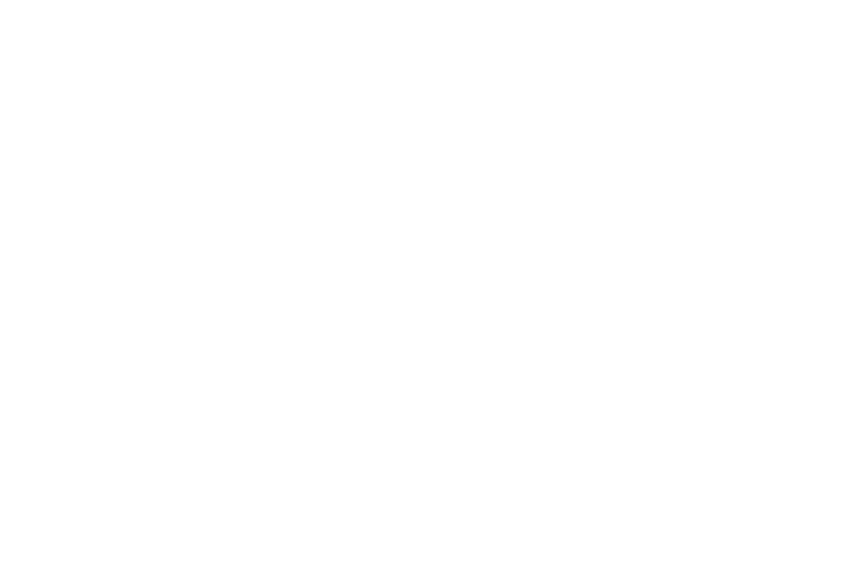

In [13]:
remove_dim = False
pca = False
# latent_dim += 1
latent_dim = 3
k = 16
bsize = 1024

# NOTE: currently the train and test sets are combined

# split = int(len(x_train)*0.8)
# x_train, x_val = x_train[:split], x_train[split:]
# y_train, y_val = y_train[:split], y_train[split:]

x_train = np.concatenate([x_train, x_test], axis=0)
y_train = np.concatenate([y_train, y_test], axis=0)

# plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
# g = plot(x_train, y_train)
g = plot(x_test, y_test)

In [14]:
if pca:
    n_clusters = latent_dim + 1
else:
    n_clusters = latent_dim

batch_sizes = {
    'Unlabeled': bsize,
    'Labeled': bsize,
    'Orthonorm': bsize,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape, name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape, name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape, name='OrthonormInput'),
    }
spectral_net = SpectralNet(inputs, arch,
            None, y_true, y_train_labeled_onehot,
            n_clusters, affinity='full', scale_nbr=k, n_nbrs=k, 
            batch_sizes=batch_sizes, siamese_net=None, 
            x_train=x_train, have_labeled=len(x_train))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [15]:
spectral_net.train(
        x_train, np.zeros_like(x_train[0:0]), x_test,
        lr=5e-5, drop=0.1, patience=30, num_epochs=40)

Epoch: 0, loss=62.794270, val_loss=0.359972
Epoch: 1, loss=21.415357, val_loss=0.055308
Epoch: 2, loss=9.137705, val_loss=0.037748
Epoch: 3, loss=7.307098, val_loss=0.034539
Epoch: 4, loss=6.399869, val_loss=0.029396
Epoch: 5, loss=5.955652, val_loss=0.029292
Epoch: 6, loss=5.644696, val_loss=0.026580
Epoch: 7, loss=5.315476, val_loss=0.024983
Epoch: 8, loss=4.805272, val_loss=0.022368
Epoch: 9, loss=4.071927, val_loss=0.018387
Epoch: 10, loss=3.325208, val_loss=0.016785
Epoch: 11, loss=2.993560, val_loss=0.015318
Epoch: 12, loss=2.848695, val_loss=0.014863
Epoch: 13, loss=2.782511, val_loss=0.014400
Epoch: 14, loss=2.724526, val_loss=0.014193
Epoch: 15, loss=2.686512, val_loss=0.013910
Epoch: 16, loss=2.652672, val_loss=0.013918
Epoch: 17, loss=2.648252, val_loss=0.013688
Epoch: 18, loss=2.605987, val_loss=0.013526
Epoch: 19, loss=2.610112, val_loss=0.013488
Epoch: 20, loss=2.562408, val_loss=0.013358
Epoch: 21, loss=2.560216, val_loss=0.013375
Epoch: 22, loss=2.589507, val_loss=0.013

(array([62.7942695 , 21.41535677,  9.13770454,  7.30709806,  6.39986874,
         5.95565154,  5.64469643,  5.31547593,  4.80527239,  4.07192691,
         3.32520772,  2.99356013,  2.84869513,  2.7825109 ,  2.72452592,
         2.68651151,  2.6526721 ,  2.64825182,  2.60598694,  2.61011217,
         2.56240834,  2.56021629,  2.58950695,  2.58161823,  2.53661885,
         2.5557375 ,  2.56030013,  2.57600597,  2.54394883,  2.54478939,
         2.55145505,  2.53409873,  2.53533118,  2.53082755,  2.53266278,
         2.52583169,  2.53358243,  2.53273914,  2.5381169 ,  2.54424434]),
 array([0.35997224, 0.05530794, 0.03774782, 0.03453921, 0.02939556,
        0.02929233, 0.02658013, 0.02498258, 0.02236815, 0.01838742,
        0.01678537, 0.01531828, 0.0148631 , 0.01439973, 0.01419256,
        0.01390953, 0.01391807, 0.01368775, 0.01352623, 0.01348793,
        0.01335759, 0.01337474, 0.01335874, 0.01324063, 0.01319287,
        0.01327039, 0.01328933, 0.01319255, 0.01305097, 0.0130974 ,
      

<IPython.core.display.Javascript object>


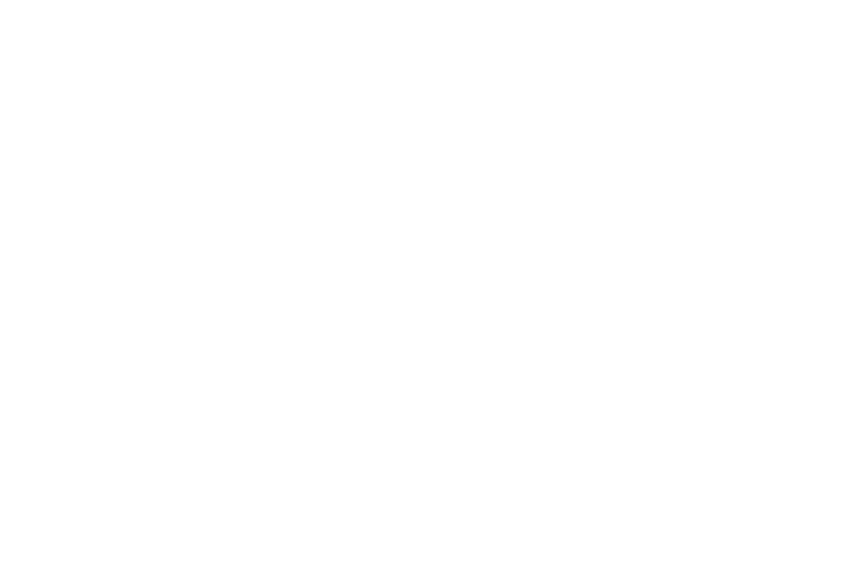

range of y_pred values: 1.752405047416687 - -1.299028992652893


In [16]:
y_pred = spectral_net.predict(x_test)
g = plot(y_pred[:,:3], y_test)
print('range of y_pred values: {} - {}'.format(np.max(y_pred), np.min(y_pred)))

In [17]:
# SHOW EMBEDDINGS WITH IM_SCATTER
# _ = imscatter(v[:,1], v[:,2], x_all)
if 'mnist' in dataset:
    %matplotlib inline
    _ = imscatter(y_pred[:,0], y_pred[:,2], x_test, shape=(28, 28))

<IPython.core.display.Javascript object>


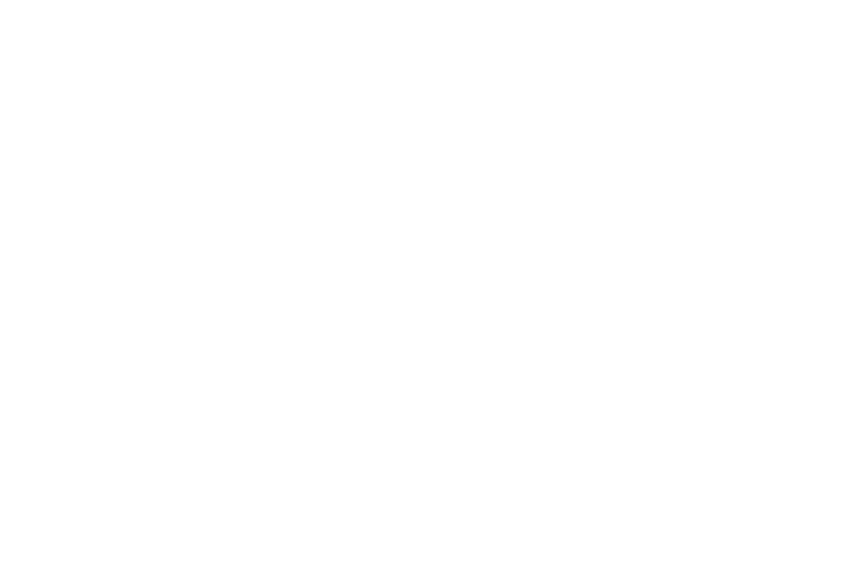

In [18]:
# now plot all the dimensions of spectralnet
y_pred_embedded = TSNE().fit_transform(y_pred)
g = plot(y_pred_embedded[:,:2], y=y_test)

In [19]:
svg = SVG(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[-1], remove_dim=remove_dim, pca=pca, k=k, alpha=1.)

NO PCA
IMPORTANT (?, 16)
z_mu_nb (?, 16, 3)
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

IMPORTANT (?, 16)


In [20]:
if pca:
    svg.train_pca(x_train, epochs=600)
    svg.pca_layers[0].trainable = False
    svg.pca_layers[1].trainable = False

In [21]:
if pca:
    y_pred = svg.pc.predict(x_test)
    plt.axis('equal')
    g = plot(y_pred[:,:3], y_test)

In [22]:
# tf_get([svg.input], [svg.loss], x_train)
svg.train(x_train, epochs=1500, batch_size=bsize)

0 [VAE loss: 13638.9912109375] [kl_loss: 9440.3505859375] [pca_loss: 0.0] [manifold_loss: 327.79534912109375] [on_manifold_loss: 0.0] [off_manifold_loss: 327.79534912109375]
vector covariance:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0.77763635 0.6065103  0.7536683 ]]
25 [VAE loss: 4130.39013671875] [kl_loss: 3991.636474609375] [pca_loss: 0.0] [manifold_loss: 52.932212829589844] [on_manifold_loss: 0.0] [off_manifold_loss: 52.932212829589844]
vector covariance:
 [[ 0.95289636  0.04765953  0.29952824]
 [-0.2872488   0.4587953   0.84082997]
 [-0.09734857 -0.88726294  0.4508745 ]]
[[ 0.6774423  -0.4702839   0.5656015 ]
 [-0.06802132  0.7255768   0.6847711 ]
 [-0.73242414 -0.50236577  0.45954704]]
[[0.81034505 0.15093108 0.11501304]]
50 [VAE loss: 3984.88232421875] [kl_loss: 3980.9765625] [pca_loss: 0.0] [manifold_loss: 26.252931594848633] [on_manifold_loss: 0.0] [off_manifold_loss: 26.252931594848633]
vector covariance:
 [[ 0.9916378   0.12904248  0.0014

KeyboardInterrupt: 

# ANALYSIS

In [23]:
%matplotlib

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


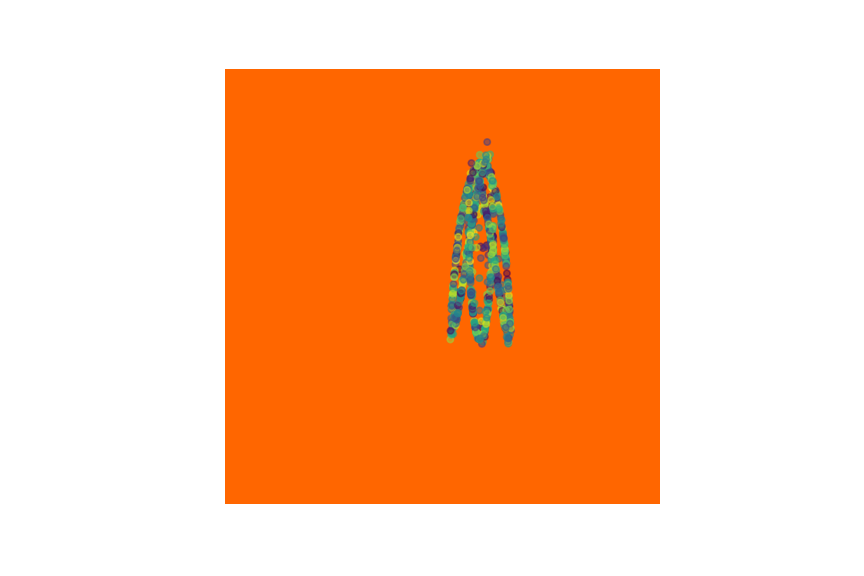

In [24]:
# pick subset size
n_p = min(1000, len(x_test))
p = np.random.permutation(len(x_test))[:n_p]
x_test_p = x_test[p]
y_test_p = y_test[p]

# plot generated points
x_gen = svg.generate_from_samples(x_train)
# g = plot(x_gen, y_train, x2=x_train, s2=0)
p_train = np.random.permutation(len(x_train))[:n_p]
g = plot(x_gen[p], y_train[p_train])

In [25]:
cov_dim = latent_dim

In [26]:
# get number of neighbors within one standard deviation of each element in x_test
_, _mu, _sigma_v, _sigma_lam, _x_enc = svg.generate_from_samples(x_test_p, return_mu_sigma=True)
_sigma_v = _sigma_v.reshape(-1, cov_dim, cov_dim)

num_close = []
for i in range(len(_mu)):
    l, v, m = np.exp(0.5 * -_sigma_lam[i,:]), _sigma_v[i,:], _mu[i,:]
    left_cov = np.einsum('ij,j->ij', v, l)
    cov = np.einsum('ij,kj->ik', left_cov, v)
    scaled_dists = np.einsum('jk,ik->ij', cov, _mu - m)
    # consider as neighbors all points within the variance of x_i
    less_than_std = np.abs(scaled_dists) < 1
    less_than_std = np.logical_and(less_than_std[:,0], less_than_std[:,1])
    # split neighbors into those of the same class and those of a different class
    same, diff = (y_test_p[less_than_std] == y_test[i]), (y_test_p[less_than_std] != y_test_p[i])
    num_close.append((np.sum(same), np.sum(diff)))

In [27]:
v_flattened = _sigma_v.reshape((len(_sigma_v), -1))
centered = (v_flattened - np.mean(v_flattened, axis=0))
_cov = centered.T.dot(centered) / len(_sigma_v)
print('MEAN VALUE\n', np.mean(np.sqrt(_sigma_lam), axis=0))
print('MEAN VECTOR\n', np.mean(_sigma_v, axis=0))
print('COVARIANCE VALUE')
centered_val = _sigma_lam - np.mean(_sigma_lam, axis=0)
_cov_val = centered_val.T.dot(centered_val) / len(_sigma_lam)
plt.imshow(_cov_val, cmap='hot', interpolation='nearest')

MEAN VALUE
 [0.88462094 0.3581037  0.39887635]
MEAN VECTOR
 [[-0.46451309  0.17440753 -0.21644699]
 [-0.35016674 -0.4968881   0.22687373]
 [-0.02600715  0.27573687  0.58480435]]
COVARIANCE VALUE


In [28]:
print('COVARIANCE VECTOR')
plt.imshow(_cov, cmap='hot', interpolation='nearest')

COVARIANCE VECTOR


### COVARIANCE TESTING

In [29]:
get_fn1 = K.function([svg.input], [svg.sqrt_sigma])
get_fn2 = K.function([svg.input], [svg.x_enc])
get_fn = K.function([svg.input], [svg.sqrt_sigma, svg.x_enc])

In [30]:
epsilon = np.random.normal(0, .5, size=_mu.shape)

In [31]:
a__ = np.zeros(12)
len(a__[:-1])

11

In [32]:
print(np.mean(np.isfinite(_mu[:,0])), np.mean(np.isfinite(_mu[:,1])))

1.0 1.0


In [35]:
get_fn = K.function([svg.input], [svg.z_mu, svg.x_enc])
_mu, _x_enc = predict_with_K_fn(get_fn, x_test_p)
# plt.scatter(_mu[:,0], _mu[:,1])
plt.scatter(_x_enc[:,0], _x_enc[:,1])

AttributeError: 'NoneType' object has no attribute 'sqrt'

<IPython.core.display.Javascript object>


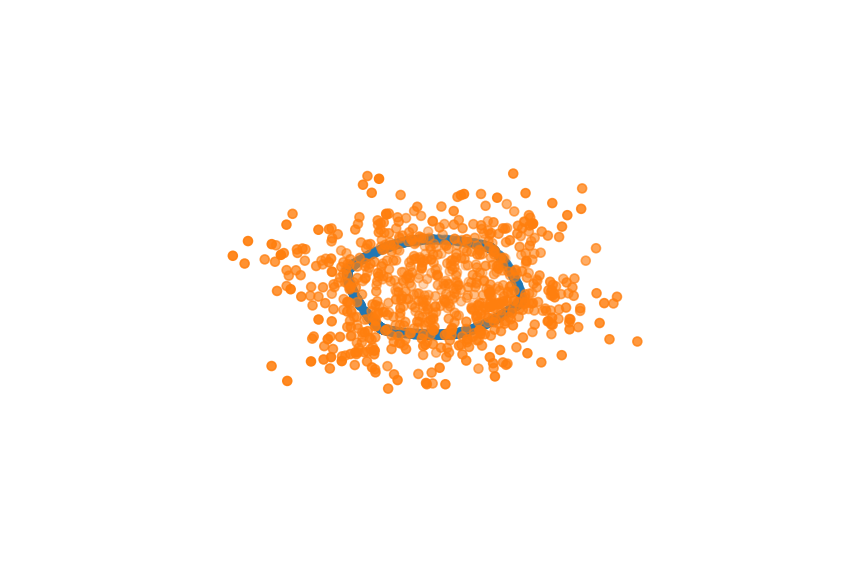

In [36]:
g = plt.figure()
ax = g.add_subplot(111, projection='3d')
ax.set_axis_off()
ax.scatter(_mu[:,0], _mu[:,1], _mu[:,2])
ax.scatter(_x_enc[:,0], _x_enc[:,1], _x_enc[:,2])

ALSO (750, 3, 3) (750, 3, 3)
ERROR 14.795594239550459


<IPython.core.display.Javascript object>


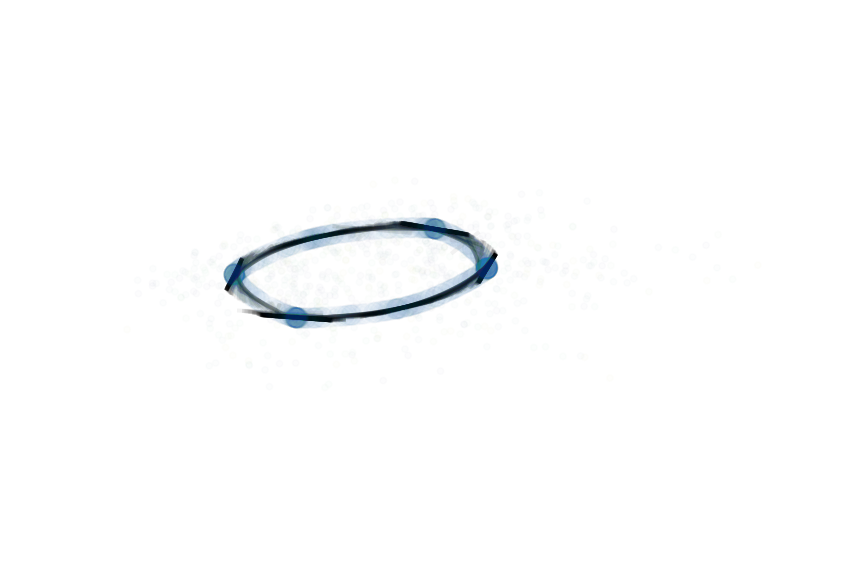

(-1.0853614896535873,
 4.030575343966484,
 -2.0363152265548705,
 4.635826849937439)

In [40]:
# compute sigmas
_, _mu, _sigma_v, _sigma_lam, _x_enc = svg.generate_from_samples(x_test_p, return_mu_sigma=True)
_sigma_v = _sigma_v.reshape((-1, cov_dim, cov_dim))
# _sigma_v = np.einsum('ijk->ikj', _sigma_v)
# _sigma_lam = np.flip(_sigma_lam, axis=1)
k_ = 1
_sigma = np.einsum('ijk,ilk->ijl', np.einsum('ijk,ik->ijk', _sigma_v[:,:,:k_], np.sqrt(_sigma_lam[:,:k_])), _sigma_v[:,:,:k_])
# _sigma = np.einsum('ijk,ilk->ijl', np.einsum('ijk,ik->ijk', _sigma_v, np.sqrt(_sigma_lam)), _sigma_v)


# verify sigmas
_z_sqrt_var = predict_with_K_fn(get_fn1, x_test_p)[0].reshape((-1, cov_dim, cov_dim))

# # verify encoding
# _x_enc = predict_with_K_fn(get_fn2, x_test_p)[0]

print("ALSO", _sigma.shape, _z_sqrt_var.shape)
print('ERROR', np.linalg.norm(_sigma - _z_sqrt_var))

# epsilon = np.random.normal(size=_mu.shape)
perturbations = np.einsum('ijk,ik->ij', _sigma, epsilon)
# perturbations = epsilon

single_perturbed_x = np.array([_mu[0,:]] * len(_mu)) + np.einsum('jk,ik->ij', _sigma[0,:], epsilon)
perturbed_x = _mu + perturbations
# g = plot(x=_mu, alpha=0.0)
# g = plot(x=perturbed_x, y=y_test, x2=_mu, s2=100)
g = plot(_x_enc, y=y_test, x2=_mu, s2=100, alpha=0.01)
# g = plot(_x_enc, y=y_test_p, alpha=0.1)
# plt.figure()

idxs = np.random.permutation(len(_mu))
for i in idxs:
    idx = np.argsort(_sigma_lam[i])[1]
#     idx = 0
    delta = _sigma_v[i,:,idx] * np.sqrt(_sigma_lam[i, idx])
    start = _mu[i] + delta
    end = _mu[i] - delta
    coords = [[s, e] for s, e in zip(start, end)]
    plt.plot(*coords, 'k-', lw=2, alpha=.05)
    
plt.axis('equal')

# plt.scatter(_mu[idxs, 0], _mu[idxs, 1], s=200)
# plt.plot([0, 1], [1, 2])

<IPython.core.display.Javascript object>


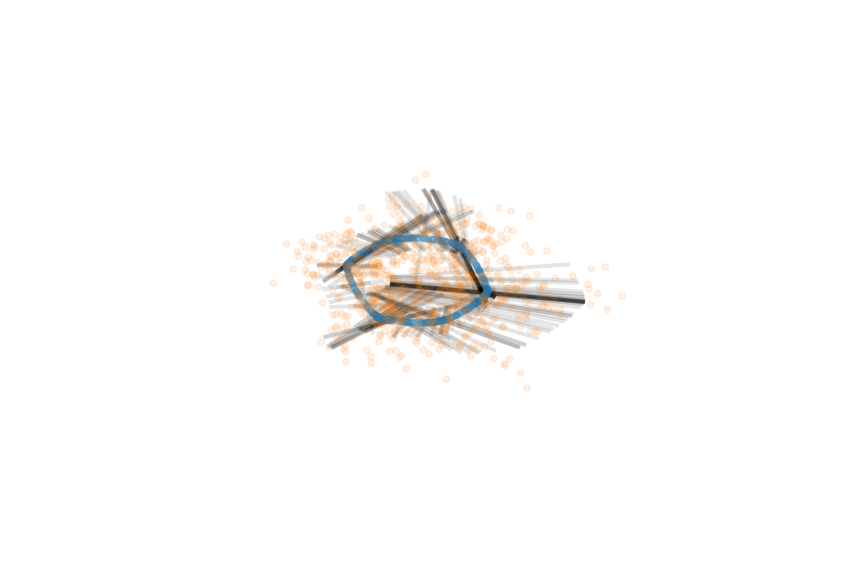

In [41]:
single_perturbed_x = np.array([_mu[0,:]] * len(_mu)) + np.einsum('jk,ik->ij', _sigma[0,:], epsilon)
perturbed_x = _mu + perturbations
g = plot(_mu, x2=_x_enc, alpha=0.1, alpha2=0.1)
plt.axis('equal')

idxs = np.random.permutation(len(_mu))[:100]
for i in idxs:
    idx = np.argmax(_sigma_lam[i])
    delta = _sigma_v[i, idx] * np.sqrt(_sigma_lam[i, idx]) * 2
    start = _mu[i] + delta
    end = _mu[i] - delta
    coords = [[s, e] for s, e in zip(start, end)]
    plt.plot(*coords, 'k-', lw=2, alpha=.1)
    
for i in idxs:
    idx = np.argmin(_sigma_lam[i])
    delta = _sigma_v[i,:,idx] * np.sqrt(_sigma_lam[i, idx]) * 2
    start = _mu[i] + delta
    end = _mu[i] - delta
    coords = [[s, e] for s, e in zip(start, end)]
    plt.plot(*coords, 'k-', lw=2, alpha=.1)

In [42]:
# CHECKING MATRIX MATH

# TEST MATRIX STACK x VECTOR STACK (REPRESENTING DIAGONALS)
n_stacks = min(1500, len(_sigma_lam))
n = 10

# generate matrices
matrices = []
diagonals = []
products = []
for i in range(n_stacks):
    matrix = _sigma_v[i,:,:]
    diagonal = np.sqrt(_sigma_lam[i,:])
    product = np.dot(np.dot(matrix, np.diag(diagonal)), matrix.T)
    matrices.append(matrix)
    diagonals.append(diagonal)
    products.append(product)
    
matrix_stack = np.concatenate([np.expand_dims(m, axis=0) for m in matrices], axis=0)
diagonals_stack = np.concatenate([np.expand_dims(d, axis=0) for d in diagonals], axis=0)
product_stack = np.einsum('ijk,ilk->ijl', np.einsum('ijk,ik->ijk', matrix_stack, diagonals_stack), matrix_stack)

diffs = []
diffs2 = []
diffs3 = []
for i in range(n_stacks):
    diff = np.sum(products[i] - product_stack[i,:,:])
    diff2 = np.sum(products[i] - _sigma[i,:,:])
    diff3 = np.sum(products[i] - _z_sqrt_var[i,:,:])
    diffs.append(diff)
    diffs2.append(diff2)
    diffs3.append(diff3)
    
print("ERRORS")
print(sum(diffs))
print(sum(diffs2))
print(sum(diffs3))

ERRORS
-2.196017619051499e-16
529.02633083752
3.51809343277491e-06


In [43]:
i_ = np.random.randint(0, len(_mu))
# i_ = 0
print(_sigma[i_].dot(_sigma_v[i_]))
print(np.linalg.norm(_sigma[i_].dot(_sigma_v[i_])))
print(np.sqrt(_sigma_lam[i_]))
print(_sigma_v[i_])
print(epsilon[i_])
print(_sigma[i_].dot(epsilon[i_]))
print(perturbed_x[i_])
print(_mu[i_])

[[-6.65102643e-02  1.35329038e-08  8.58203823e-11]
 [-9.03290540e-01  1.83793345e-07  1.16554550e-09]
 [ 1.63911478e-01 -3.33512171e-08 -2.11500375e-10]]
0.9204479276452238
[0.92044765 0.31982516 0.41842427]
[[-0.07225859  0.98548639 -0.15360826]
 [-0.98135984 -0.04275125  0.18736428]
 [ 0.17807797  0.16428362  0.97020572]]
[-1.15541996  0.13049131 -0.05586871]
[ 0.00362607  0.04924639 -0.00893627]
[ 0.14482063  1.7969981  -0.34460802]
[ 0.14119457  1.74775171 -0.33567175]


In [ ]:
# i_ = np.random.randint(0, len(_mu))
# tmp = np.expand_dims(_sigma[i_].dot(epsilon[i_]), axis=0)
# tmp2 = perturbed_x[i_-1:i_]
# tmp3 = np.expand_dims(np.einsum('ij,j->j', _sigma[i_], epsilon[i_]), axis=0)
# tmp4 = np.expand_dims(np.einsum('ij,j->i', _sigma[i_], epsilon[i_]), axis=0)
# print('tmp', tmp)
# print('tmp2', tmp2)
# print('tmp3', tmp3, np.linalg.norm(tmp3/_mu[i_]))
# print('tmp4', tmp4, np.linalg.norm(tmp4/_mu[i_]))
# g = plot(_mu[i_:i_+1], x2=_mu[i_] + tmp, s=1000, s2=300)
# plt.scatter(_mu[:,0], _mu[:,1])
# idx = np.argmax(_sigma_lam[i])
# delta = _sigma_v[i_,:,idx] * np.sqrt(_sigma_lam[i_, idx])
# start = _mu[i_] + delta
# end = _mu[i_] - delta
# plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', lw=2, alpha=1)
# plt.axis('equal')

### BURST TESTING

In [44]:
# differentiate decoder with respect to inputs to compute another jacobian, and then evaluate it on the same point
_jacobian = [tf.expand_dims(tf.gradients(svg.x_recon[:,i], svg.x_enc)[0], 1) for i in range(svg.x_recon.shape[1])]
jacobian = tf.reduce_sum(tf.concat(_jacobian, axis=1), axis=0)
v = tf.reshape(svg.v, (-1, cov_dim, cov_dim))
v = tf.Print(v, [tf.shape(v), tf.shape(svg.e)], 'PRINT')
temp = tf.einsum('ijk,ik->ijk', v, tf.sqrt(svg.e))
print(v.get_shape(), svg.e.get_shape(), temp.get_shape())
B = tf.einsum('ijk,ilk->ijl', temp, v)
B = tf.reduce_mean(B, axis=0)
cov = tf.matmul(jacobian, tf.matmul(B, jacobian, transpose_b=True))
cov = tf.reshape(cov, (x_test[0].shape[0], x_test[0].shape[0]))

(?, 3, 3) (?, 3) (?, 3, 3)


In [45]:
# create burst from a point and compute covariance matrix
burst_size = 1000
rand_idx = np.random.randint(len(x_test))
x_ = x_test[rand_idx]
# x_ = np.array((np.cos(.25), np.sin(.25)))
x_arr = np.array([x_] * burst_size)
x_rec, z_mu, z_sigma_v, z_sigma_lam, _x_enc = svg.generate_from_samples(x_arr, return_mu_sigma=True)

cov_burst = np.cov((x_rec - np.mean(x_rec, axis=0)).T)

# run gradient burst"
# cov_grad = K.get_session().run([svg.x_recon, cov, B, jacobian], feed_dict={svg.input: np.array([x_]*1)})
cov_grad = K.get_session().run([cov], feed_dict={svg.input: np.array([x_]*1)})[0]

In [46]:
cov_burst

array([[ 0.12720045, -0.01654181, -0.08315268],
       [-0.01654181,  0.16168492,  0.07661439],
       [-0.08315268,  0.07661439,  0.20841891]])

In [47]:
cov_grad

array([[0.07036063, 0.24690919, 0.20424591],
       [0.24690919, 0.872841  , 0.7260596 ],
       [0.20424591, 0.72605956, 0.61026245]], dtype=float32)

In [48]:
l_burst, _ = np.linalg.eig(cov_burst)
l_grad, _ = np.linalg.eig(cov_grad)
l_burst = np.sort(l_burst)[::-1]
l_grad = np.sort(l_grad)[::-1]
print('l_burst:', l_burst, l_burst/l_burst[0])
print('l_grad:', l_grad, l_grad/l_grad[0])

l_burst: [0.3004459  0.13183274 0.06502565] [1.         0.43879027 0.21643048]
l_grad: [1.5488348e+00 4.3795225e-03 2.4978377e-04] [1.0000000e+00 2.8276241e-03 1.6127205e-04]


<IPython.core.display.Javascript object>


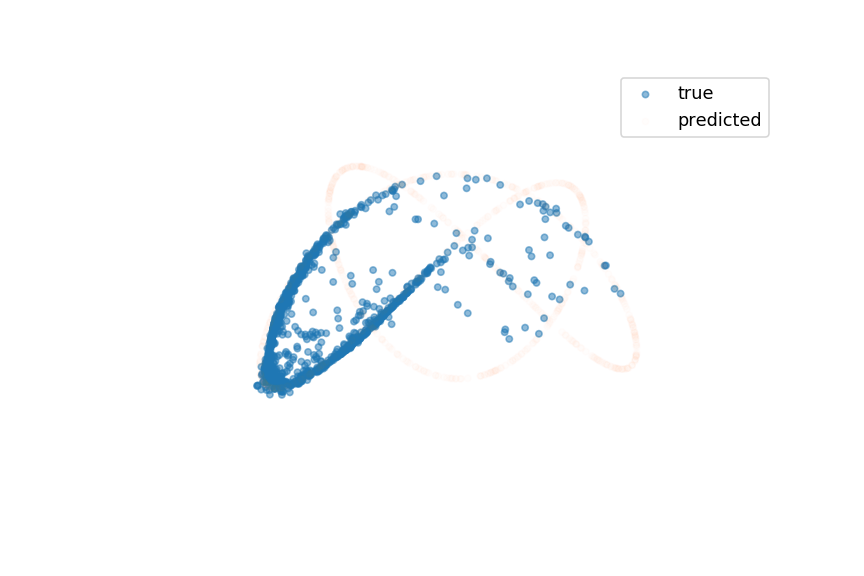

In [49]:
if x_rec.shape[1] <= 3:
    g = plot(x_rec, x2=x_test, label1='true', label2='predicted', alpha2=0.01)

<IPython.core.display.Javascript object>


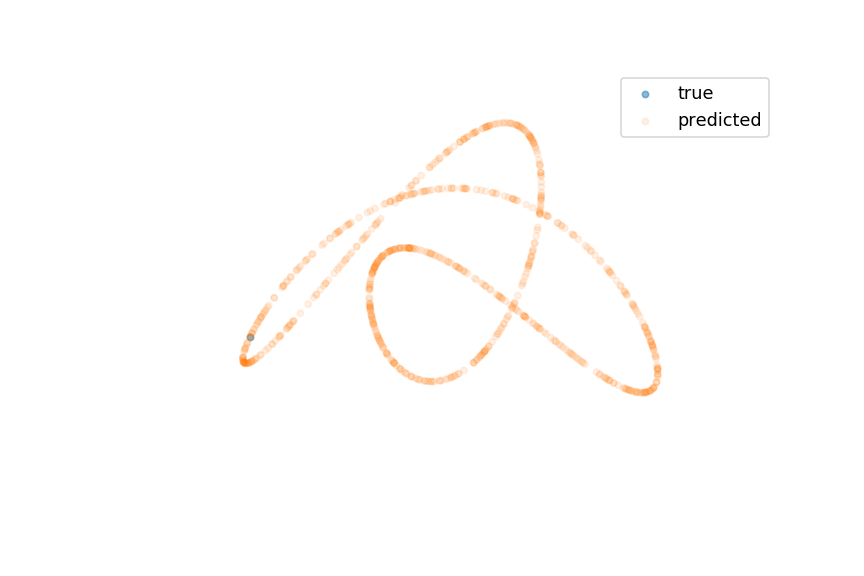

In [50]:
if x_rec.shape[1] <= 3:
    x__ = np.expand_dims(x_, axis=0)
    g = plot(x__, x2=x_test, alpha2=.1, label1='true', label2='predicted')

<IPython.core.display.Javascript object>


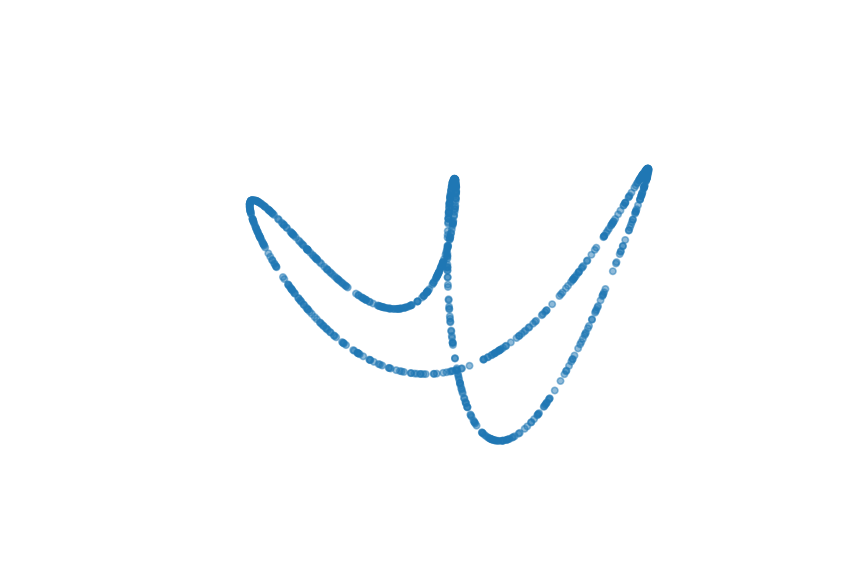

In [51]:
g = plot(x_test)

### BILIPSCHITZ TESTING

In [52]:
# TEST BILIP CONDITION
k_nbrs = 5
from annoy import AnnoyIndex
from scipy.spatial.distance import cdist

x_shuffled = np.random.permutation(x_all)
f = partial(svg.generate_from_samples, return_mu_sigma=True)
_, mu_shuffled, _, _, _ = f(x_shuffled)
x_recon_shuffled = svg.decoder.predict(mu_shuffled)

def bilip(mu, recon, k, num_trees=25):
    # Goal: for each point z_i, find its nearest neighbors on the manifold (mu_nbrs)
    # then get the corresponding reconstructed points in the original space
    # finally, compute (recon_i - recon_nbr)/(mu_i - mu_nbr), and get the largest and smallest values
    # create storage for data and constants
    K1s = []
    K2s = []
    x_valid = []
    
    # initialize nearest neighbor algorithm
    t_mu = AnnoyIndex(mu.shape[1])
    for i, x_i in enumerate(mu):
        t_mu.add_item(i, x_i)

    # compute nearest neighbors
    t_mu.build(num_trees)
    
    for i in range(len(mu_shuffled)):
        # get neighbors
        a_mu = t_mu.get_nns_by_item(i, k_nbrs+1)
        mu_nbrs = mu[a_mu]
        recon_nbrs = recon[a_mu]

        # compute distances between the ith point and the neighbors
        d_latent = cdist(mu[i:i+1], mu_nbrs)
        d_orig = cdist(recon[i:i+1], recon_nbrs)

        # find zero distance point in each
        d_both = np.logical_and(d_latent > 0, d_orig > 0)
        
        # there should only be at most one zero distance point here (the self 'neighbor')
        if np.sum(np.logical_not(d_both)) > 1:
            print(
            """
Some Lipschitz constants are infinity! Skipping this item:
idx:{}
d_both: {}
d_latent:
{}
d_orig:
{}

mu:
{}
mu_nbrs:
{}

recon:
{}
recon_nbrs:
{}
            """.format(i, d_both, d_latent, d_orig, mu[i], mu_nbrs, recon[i], recon_nbrs))
            continue
        
        # drop these points
        d_latent = d_latent[d_both]
        d_orig = d_orig[d_both]

        # compute upper K
        K1s.append(np.max(d_latent/d_orig))
        # computer lower K
        K2s.append(np.min(d_latent/d_orig))
        # keep valid points
        x_valid.append(x_shuffled[i])

    K1s = np.array(K1s)
    K2s = np.array(K2s)
    x_valid = np.array(x_valid)
    
    return K1s, K2s, x_valid

K1s, K2s, x_valid = bilip(mu_shuffled, x_recon_shuffled, k=4)

x_valid = np.array(x_valid)
print(np.max(K1s), np.mean(K1s), np.median(K2s))
print(np.min(K2s), np.mean(K2s), np.median(K2s))
print(np.max(K1s/K2s), np.mean(K1s/K2s), np.median(K1s/K2s))
%matplotlib inline
plt.xlabel('Ratio')
plt.ylabel('Occurence')
plt.title('Histogram of Bi-Lipschitz Ratio (K/k)')
g = plt.hist(K1s/K2s, bins=100, range=(0,2))

ImportError: No module named 'annoy'

In [53]:
g = plot(x=x_valid, y=K1s/K2s, alpha=1)
# plt.colorbar()

NameError: name 'x_valid' is not defined

In [ ]:
g = plot(x=x_recon_shuffled, s=K1s/K2s, alpha=.05)

### RANDOM WALK TESTING

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True) #, normalize_cov=0.5)
y_test_sz = np.mean(f(x_all)[3], axis=1)
sz_max = np.max(y_test_sz)
sz_min = np.min(y_test_sz)
y_test_sz = (y_test_sz - sz_min)/(sz_max - sz_min) * 5
print(np.min(y_test_sz), np.max(y_test_sz))
y_test_sz = np.exp(0.5 * y_test_sz)

In [ ]:
import matplotlib.animation

# which space do we want to plot in?
plot_latent = False
plot_idx = 1 if plot_latent else 0

x_arr = np.random.permutation(x_test)[:100]
x__ = f(x_all)[plot_idx]
x_ = f(x_arr)[plot_idx]
x_tot = np.concatenate([x_, x__], axis=0)
y_tot = np.concatenate([np.zeros(shape=(len(x_arr),)), np.ones(shape=(len(x__),))*2], axis=0)
y_sz = np.concatenate([np.ones(shape=(len(x_arr),))*5, y_test_sz], axis=0)

def update_graph(num):
    global x_arr
    global x__
    global y_tot
    x_arr, z_mu, z_sigma_v, z_sigma_lam = f(x_arr)
    # plot in latent or original space
    x_ = z_mu if plot_latent else x_arr
    
    x_ = np.concatenate([x_, x__], axis=0)
    
    if x_.shape[1] == 3:
        graph._offsets3d = (x_[:,0], x_[:,1], x_[:,2])
        ax.view_init(elev=10, azim=num*4)
    elif x_.shape[1] == 2:
        graph.set_offsets(np.c_[x_[:,0], x_[:,1]])
        
    title.set_text('Walk, time={}'.format(num))

fig = plt.figure(figsize=(12.8, 7.2))
projection = '3d' if x_.shape[1] == 3 else None
ax = fig.add_subplot(111, projection=projection)
title = ax.set_title('Walk, time=0')

if x_.shape[1] == 3:
    graph = ax.scatter(x_tot[:,0], x_tot[:,1], x_tot[:,2], c=y_tot, s=y_sz, alpha=.1)
elif x_.shape[1] == 2:
    graph = ax.scatter(x_tot[:,0], x_tot[:,1], c=y_tot, s=y_sz, alpha=0.4)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 180, 
                               interval=200, blit=False)

In [ ]:
import matplotlib.animation as animation
print("saving animation")
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
print("...")
ani.save('im_{}_inv.mp4'.format(dataset), writer=writer)
print("saved")

In [ ]:
# from IPython.display import HTML
# HTML(ani.to_html5_video(embed_limit=None))

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True, normalize_cov=0.)
def walk(f, x_arr, branch_factor=20, n_steps=10, max_size=5000):
    p = np.random.permutation(len(x_arr))[:1000]
    x_arr = x_arr[p]
    for i in range(n_steps):
        x_arr = np.array([x_arr] * branch_factor).reshape([-1, x_arr.shape[1]])
        (x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:1000]
        x_arr, z_mu, z_sigma_v, z_sigma_lam = x_arr[p], z_mu[p], z_sigma_v[p], z_sigma_lam[p]
    
    p = np.random.permutation(len(x_arr))[:1000]
    x_arr = x_arr[p]
        
    return x_arr, z_mu, z_sigma_v, z_sigma_lam

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)

p = np.random.permutation(len(x_test))[:1]
x_test_sample = x_test[p]
print('random walking on {}'.format(y_test[p]))
# x_test_sample = x_train[y_train == 5]
x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=20)

In [ ]:
x_true_n_gen = np.concatenate([x_test_sample, x_arr[:12]], axis=0)
g = plot(x_true_n_gen, y_train[:len(x_true_n_gen)], shuffle=False)

In [ ]:
p = np.random.permutation(len(p))[:1000]
g, ax = plot(x_arr, x2=x_test[p], label1='predicted', label2='true', alpha2=0.2)
# ax.scatter(x_test_sample[:,0], x_test_sample[:,1], x_test_sample[:,2], s=1000)

In [ ]:
# g = plot(z_mu, x2=f(x_test_sample)[1])
g = plot(z_mu, x2=f(x_test)[1])

In [ ]:
g = plot(x_arr, x2=x_test_sample, s2=1000)

In [ ]:
print("samar was here")